drop=0.2 Test set: Average loss: 0.0562, Accuracy: 1960/2000 (98%)
<p>drop=0Test set: Average loss: 0.0854, Accuracy: 1945/2000 (97%)

In [1]:
import torch as t
import torch.nn as nn
import torchvision 
import torch.utils.data as Date
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable as V
import time

In [2]:
class _DenseLayer(nn.Sequential):#卷积块：BN->ReLU->1x1Conv->BN->ReLU->3x3Conv
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):

        super(_DenseLayer, self).__init__()
        
        self.module1 = nn.Sequential(
                            nn.BatchNorm2d(num_input_features),
                            nn.ReLU(),
                            nn.Conv2d(num_input_features, 
                                      bn_size * growth_rate, 
                                      kernel_size=1,
                                      stride=1, 
                                      bias=False
                            
                            ),
                
                nn.BatchNorm2d(bn_size * growth_rate),
                nn.ReLU(),
                nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False),
 
                )
        
        self.drop = drop_rate 
        
    def forward(self, x):
        #print('or:',x.shape)
        new_features = self.module1(x)
        #print('new_features:',new_features.shape)
        if self.drop >0:
            new_features = F.dropout(new_features, p = self.drop, training=self.training)
            
        #print('----------------------------------------------------------------')
        return t.cat([x, new_features], dim=1)
        

##### num_input_features要為1

In [3]:
_DenseLayer1=_DenseLayer(1,4,4,0)
_DenseLayer1

_DenseLayer(
  (module1): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU()
    (2): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [4]:
test_input =V( t.randn(50, 1, 28, 28))
test_out = _DenseLayer1(test_input)

In [5]:
class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
 
# "num_layers:每个block内dense layer层数"  
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)

In [6]:
_DenseBlock2=_DenseBlock(3,1,4,4,0)
_DenseBlock2

_DenseBlock(
  (denselayer1): _DenseLayer(
    (module1): Sequential(
      (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (denselayer2): _DenseLayer(
    (module1): Sequential(
      (0): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(5, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (denselayer3): _DenseLayer(
    (module1): Sequential(
      (0): BatchNorm2d(9, eps=1e-05, momen

In [7]:
test_out = _DenseBlock2(test_input)

In [8]:
def _Transition(num_input_features, num_output_features):#过渡层，将特征图个数减半
    trans_layer = nn.Sequential(
        nn.BatchNorm2d(num_input_features),
        nn.ReLU(),
        nn.Conv2d(num_input_features, num_output_features, 1),
        nn.AvgPool2d(1, 1),#(2,2)

    )
    return trans_layer

In [9]:
_Transition3=_Transition(1,4)   #32,16
_Transition3

Sequential(
  (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): ReLU()
  (2): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 1))
  (3): AvgPool2d(kernel_size=1, stride=1, padding=0)
)

In [10]:
test_out = _Transition3(test_input)
test_out.shape

torch.Size([50, 4, 28, 28])

In [11]:
Block_config1=[2]

In [12]:
Bn_size=4
Growth_rate=32
Block_config=[6,6,6]
Out_channels=64
Drop_rate=0.2
Num_classes=10

In [13]:
class DesNET(nn.Module):
    def __init__(self, 
                 growth_rate=Growth_rate, 
                 block_config=Block_config,
                 out_channels=Out_channels,
                 bn_size=Bn_size, 
                 drop_rate=Drop_rate, 
                 num_classes=Num_classes
                ):
        
        super(DesNET,self).__init__()
        
        self.pre_layer = nn.Sequential(
                            nn.Conv2d(1, out_channels, kernel_size=7, stride=2, padding=3, bias=False ),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        
        num_features = out_channels 
        
        for i,num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, 
                                num_input_features=num_features,
                                bn_size=bn_size,
                                growth_rate=growth_rate,
                                drop_rate=drop_rate, 
            )
            
            self.pre_layer.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            
            #過度層只需要做block層-1，並且特徵要扣半
            
            if i != len(block_config)-1:
                Trans = _Transition(num_input_features = num_features, num_output_features= num_features//2)
                self.pre_layer.add_module('transition%d' % (i + 1), Trans)
                num_features = num_features // 2           
        
                
        self.pre_layer.add_module('Norm5',nn.BatchNorm2d(num_features))

        #self.classifier1 = nn.Linear(num_features, num_features//2)
        self.classifier2 = nn.Linear(num_features, num_classes)
            
            
            
            
    def forward(self,x):
        x = self.pre_layer(x)
        out = F.relu(x, inplace=True)
        out = F.avg_pool2d(out, kernel_size=7, stride=1).view(x.size(0), -1)
        #out = self.classifier1(out)
        out = self.classifier2(out)
        return out

In [14]:
DesNET121=DesNET()
DesNET121

DesNET(
  (pre_layer): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (module1): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU()
          (5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (module1): Sequential(
          (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

In [15]:
test_out = DesNET121(test_input)

In [16]:
test_out.shape

torch.Size([50, 10])

In [17]:
EPOCH=1
BATCH_SIZE=50
LR=0.001
DOWN_MNIST=False
data_trian=torchvision.datasets.MNIST(root='./mnist/',train=True,transform=torchvision.transforms.ToTensor,download=False)
data_test=torchvision.datasets.MNIST(root='./mnist/',train=False,transform=torchvision.transforms.ToTensor,download=False)
train_x = V(t.unsqueeze(data_trian.train_data,dim=1)).type(t.FloatTensor)/255
train_y= data_trian.train_labels
test_x = V(t.unsqueeze(data_test.test_data,dim=1)).type(t.FloatTensor)[:2000]/255
test_y = data_test.test_labels[:2000]
train_data=Date.TensorDataset(train_x,train_y)
train_loader=Date.DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)

D:\python\envs\two_pthon_deep\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
D:\python\envs\two_pthon_deep\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
D:\python\envs\two_pthon_deep\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
D:\python\envs\two_pthon_deep\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [18]:
optimizer=t.optim.Adam(DesNET121.parameters(),lr=LR)
loss_func=nn.CrossEntropyLoss()
training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []

In [19]:
Epoch=0
tStart = time.time()#計時開始
#time.sleep(2)
for epoch in range(1):
    
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        

        
        b_x = V(x)   # batch x
        b_y = V(y)   # batch y
        
        output = DesNET121(b_x)               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        
        b_t_x= V(test_x)
        b_t_y= V(test_y)
        
        
        
        
        
        if step % 100 == 0:
            DesNET121.eval()
            Epoch+=1
            test_output = DesNET121(test_x) 
            DesNET121.train()
            pred_y = t.max(test_output, 1)[1]#因為是relu，所以max取機率最高的機率
            tran_pred_y = t.max(output, 1)[1]
            
            training_loss.append(loss.data)
            val_loss = loss_func(test_output, b_t_y)
            validation_loss.append(val_loss.data)
            
            
            
            
            
            tran_accuracy = (tran_pred_y == y).sum().item() / float(y.size(0))
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            training_accuracy.append(tran_accuracy)
            validation_accuracy.append(accuracy)

            print('Epoch:', Epoch,'[', step * len(b_x), '/','%d'% len(train_loader.dataset),
                  '(',int(100. * step / len(train_loader)),') %]',
                  'train acc: %.2f' % tran_accuracy, '| train loss: %.4f' % loss.item(), '- |test acc: %.2f' % accuracy, '- test loss: %.4f|' % val_loss.item())
tEnd = time.time()
print('-'*100)
print ("It cost %.1f sec" % (tEnd - tStart))



Epoch: 1 [ 0 / 60000 ( 0 ) %] train acc: 0.14 | train loss: 2.3044 - |test acc: 0.11 - test loss: 2.3016|
Epoch: 2 [ 5000 / 60000 ( 8 ) %] train acc: 1.00 | train loss: 0.0763 - |test acc: 0.91 - test loss: 0.3016|
Epoch: 3 [ 10000 / 60000 ( 16 ) %] train acc: 0.90 | train loss: 0.3048 - |test acc: 0.95 - test loss: 0.1643|
Epoch: 4 [ 15000 / 60000 ( 25 ) %] train acc: 0.96 | train loss: 0.1063 - |test acc: 0.96 - test loss: 0.1411|
Epoch: 5 [ 20000 / 60000 ( 33 ) %] train acc: 0.98 | train loss: 0.0621 - |test acc: 0.96 - test loss: 0.1394|
Epoch: 6 [ 25000 / 60000 ( 41 ) %] train acc: 0.98 | train loss: 0.0694 - |test acc: 0.95 - test loss: 0.1497|
Epoch: 7 [ 30000 / 60000 ( 50 ) %] train acc: 1.00 | train loss: 0.0412 - |test acc: 0.98 - test loss: 0.0750|
Epoch: 8 [ 35000 / 60000 ( 58 ) %] train acc: 0.98 | train loss: 0.0768 - |test acc: 0.97 - test loss: 0.0981|
Epoch: 9 [ 40000 / 60000 ( 66 ) %] train acc: 1.00 | train loss: 0.0147 - |test acc: 0.96 - test loss: 0.1294|
Epoch: 1

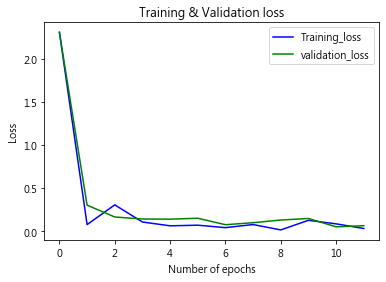

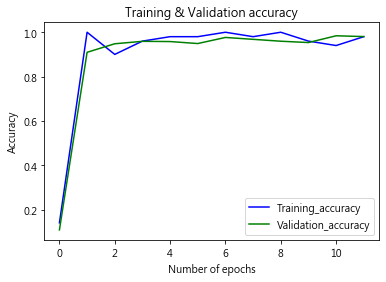

In [20]:
plt.plot(training_loss, 'b-', label='Training_loss')
plt.plot(validation_loss, 'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot( training_accuracy, 'b-', label='Training_accuracy')
plt.plot( validation_accuracy, 'g-', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
y_0_9_chance=DesNET121(test_x[:20])
y_pred=t.max(y_0_9_chance,1)[1].data.numpy().squeeze()
print('實際:',test_y[:20].numpy())
print('預測:',y_pred)

實際: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
預測: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [22]:
test_data=Date.TensorDataset(test_x,test_y)
test_loader=Date.DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)

In [23]:
DesNET121.eval()
test_loss = 0
correct = 0
for data,target in (test_loader):
    data, target = V(data, volatile=True), V(target)
    output = DesNET121(data)
    test_loss += loss_func(output, target).item()
    pred = output.data.max(1)[1] # get the index of the max log-probability
    correct += pred.eq(target.data).cpu().sum()

test_loss = test_loss
test_loss /= len(test_loader) # loss function already averages over batch size

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

D:\python\envs\two_pthon_deep\lib\site-packages\ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """



Test set: Average loss: 0.1081, Accuracy: 1931/2000 (97%)



In [24]:
from sklearn.metrics import classification_report
y_all=DesNET121(test_x)
y_pred_all=t.max(y_all,1)[1].data.numpy().squeeze()
target_names = ['0', '1', '2','3','4','5','6','7','8','9']
print(classification_report(test_y.numpy(),y_pred_all,target_names=target_names))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       175
           1       0.98      0.99      0.99       234
           2       0.99      0.98      0.98       219
           3       0.94      1.00      0.96       207
           4       0.99      0.98      0.98       217
           5       0.98      0.97      0.97       179
           6       1.00      0.97      0.99       178
           7       0.97      0.97      0.97       205
           8       0.99      0.82      0.90       192
           9       0.86      0.98      0.92       194

    accuracy                           0.97      2000
   macro avg       0.97      0.96      0.96      2000
weighted avg       0.97      0.97      0.97      2000



In [25]:
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=test_y.numpy(), y_pred=y_pred_all)
print(confmat)

[[174   0   0   0   0   0   0   1   0   0]
 [  0 232   0   1   0   0   0   1   0   0]
 [  1   2 214   0   0   0   0   2   0   0]
 [  0   0   0 206   0   0   0   1   0   0]
 [  0   0   0   0 213   0   0   0   0   4]
 [  0   0   0   5   0 173   0   1   0   0]
 [  1   1   0   0   0   2 173   0   1   0]
 [  0   1   1   0   1   0   0 198   0   4]
 [  0   1   2   7   1   1   0   1 157  22]
 [  0   0   0   1   1   1   0   0   0 191]]
